In [120]:
import keras
import keras.backend as K
import keras.layers as L

import tensorflow as tf

import numpy as np
import pandas as pd
from sklearn import datasets
from scipy.spatial.distance import jensenshannon
import scipy
from sklearn import metrics
import matplotlib.pyplot as plt

In [14]:
true_faces = datasets.fetch_olivetti_faces()["images"] * 2 - 1

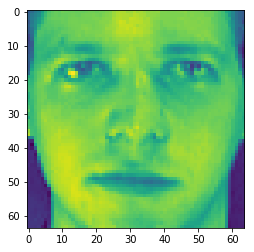

In [15]:
plt.imshow(true_faces[0])

In [59]:
true_faces.std()

0.34503055

# GAN Model

### Generative

In [5]:
def build_generator():
    return keras.models.Sequential([
        L.Reshape((4, 4, 512), input_shape=(4*4*512,)),
        
        L.Deconv2D(256, kernel_size=5, strides=2, padding="same", kernel_initializer=normal_initialiser),
        L.ReLU(),
        L.Dropout(0.25),
        L.BatchNormalization(),
        
        L.Deconv2D(128, kernel_size=5, strides=2, padding="same", kernel_initializer=normal_initialiser),
        L.ReLU(),
        L.Dropout(0.25),
        L.BatchNormalization(),
        
        L.Deconv2D(64, kernel_size=5, strides=2, padding="same", kernel_initializer=normal_initialiser),
        L.ReLU(),
        L.Dropout(0.25),
        L.BatchNormalization(),
        
        L.Deconv2D(1, kernel_size=5, strides=2, activation="tanh", padding="same", kernel_initializer=normal_initialiser),
        L.Reshape((64, 64)),
    ], name="generator")

In [383]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_53 (Reshape)         (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_25 (Conv2DT (None, 8, 8, 256)         3277056   
_________________________________________________________________
leaky_re_lu_93 (LeakyReLU)   (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_26 (Conv2DT (None, 16, 16, 128)       819328    
_________________________________________________________________
leaky_re_lu_94 (LeakyReLU)   (None, 16, 16, 128)       0         
__________

In [350]:
generator.compile(
    # Pick proper values for these
    optimizer="adam",
    loss="mae",
    metrics=["accuracy"],
)

### Discriminator

In [215]:
def Kmean_var(batch):
    return K.reshape(K.tile(K.mean(K.concatenate([
            K.mean(batch, axis=0, keepdims=True),
            K.var(batch, axis=0, keepdims=True)
            ], axis=0), axis=1), (K.shape(batch)[0],)), (-1, 2))

def mean_var(batch):
    return np.tile(np.mean(np.concatenate([
            np.mean(batch, axis=0, keepdims=True), 
            np.var(batch, axis=0, keepdims=True)]), axis=1), (batch.shape[0], 1))


def MinibatchLayer(x, n_kernals=1):
    # https://github.com/keras-team/keras/pull/3677#issuecomment-244825626
    x = L.Dense(n_kernals, activation="linear", use_bias=False, name="MB_Dense")(x)
    return L.Lambda(Kmean_var)(x)

In [162]:
normal_initialiser = keras.initializers.RandomNormal(stddev=0.02)

def build_discriminator():
    inputs = L.Input(shape=(64, 64))
    
    # Minibatch discrimination
    mb = L.Flatten()(inputs)
    mb = MinibatchLayer(mb, 1)
    
    
    x = L.Reshape((64, 64, 1))(inputs)
    # Add noise to input image
    x = L.GaussianNoise(0.01)(x)
    
    # Convolutions
    x = L.Conv2D(4, kernel_size=3, strides=2, kernel_initializer=normal_initialiser)(x)
    x = L.LeakyReLU(0.2)(x)
    x = L.BatchNormalization()(x)
    
    x = L.Conv2D(16, kernel_size=3, strides=2, kernel_initializer=normal_initialiser)(x)
    x = L.LeakyReLU(0.2)(x)
    x = L.BatchNormalization()(x)
    
    # Dense
    x = L.Flatten()(x)
    x = L.Dense(128, kernel_initializer=normal_initialiser)(x)
    x = L.LeakyReLU(0.2)(x)
    x = L.BatchNormalization()(x)

    x = L.Dense(32, kernel_initializer=normal_initialiser)(x)
    x = L.LeakyReLU(0.2)(x)
    x = L.BatchNormalization()(x)
    
    x = L.Concatenate()([x, mb])

    x = L.Dense(1, kernel_initializer=normal_initialiser)(x)
    outputs = L.Activation("sigmoid")(x)
    
    
    return keras.models.Model(inputs, outputs, name="discriminator")

In [216]:
build_discriminator().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, 64, 64)       0                                            
__________________________________________________________________________________________________
reshape_20 (Reshape)            (None, 64, 64, 1)    0           input_33[0][0]                   
__________________________________________________________________________________________________
gaussian_noise_13 (GaussianNois (None, 64, 64, 1)    0           reshape_20[0][0]                 
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 31, 31, 4)    40          gaussian_noise_13[0][0]          
__________________________________________________________________________________________________
leaky_re_l

In [217]:
discriminator.compile(
    # Pick proper values for these
    optimizer="sgd",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

### Combined model

In [32]:
# https://www.inference.vc/an-alternative-update-rule-for-generative-adversarial-networks/
def gan_loss(y_true, y_pred):
    # "Alternative M-step"
    return -np.log(y_pred)

def gan_loss2(y_true, y_pred):
    # "Alternative M-step #2"
    return -np.log(y_pred / (1-y_pred))

# https://www.inference.vc/an-alternative-update-rule-for-generative-adversarial-networks/
def Kgan_loss(y_true, y_pred):
    # "Alternative M-step"
    return -K.log(y_pred)

def Kgan_loss2(y_true, y_pred):
    # "Alternative M-step #2"
    return -K.log(y_pred / (1-y_pred))

In [218]:
generator = build_generator()

discriminator = build_discriminator()
discriminator.compile(
    optimizer="sgd",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

discriminator.trainable = False

noise_input = keras.layers.Input((4*4*512,))
generated_img = generator(noise_input)
discriminator_output = discriminator(generated_img)
full_model = keras.models.Model(noise_input, discriminator_output)

full_model.compile(optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5),
                  loss=Kgan_loss2,
                  metrics=["accuracy"])

In [219]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 8192)              0         
_________________________________________________________________
generator (Sequential)       (None, 64, 64)            4304641   
_________________________________________________________________
discriminator (Model)        (None, 1)                 470539    
Total params: 4,775,180
Trainable params: 4,303,745
Non-trainable params: 471,435
_________________________________________________________________


In [10]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 64, 64, 1)         0         
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 4)         40        
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 31, 31, 4)         0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 31, 31, 4)         16        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 16)        592       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 15, 15, 16)        0         
__________

C:\Users\billy\AppData\Local\conda\conda\envs\ML\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


# Training the model

In [220]:
def train_batch(batch_size, last_losses=None):
    if last_losses:
        real_loss, gen_loss, tot_loss, full_loss = last_losses
    
    
    # create training data
    real_imgs = true_faces[np.random.randint(len(true_faces), size=batch_size)]
    
    # 0.9 labels penalise overfitting
    real_labels = np.ones((batch_size, 1)) * 0.9
    
    # Random labels between [0.7, 1.2]
#     real_labels = np.random.rand(batch_size, 1) * 0.5 + 0.7

    noise = np.random.normal(size=(batch_size, 4*4*512))
    gen_imgs = generator.predict(noise)
    
    gen_labels = np.zeros((batch_size, 1))
    # Random labels between [0, 0.3]
#     gen_labels = real_labels = np.random.rand(batch_size, 1) * 0.3
    
    
    ## if discriminator is not 100% accurate, train it
#     if not last_losses or tot_loss[1] < 1:

    # train discriminator
    discriminator.trainable = True
    real_loss = discriminator.train_on_batch(real_imgs, real_labels)
    gen_loss = discriminator.train_on_batch(gen_imgs, gen_labels)
    tot_loss = np.add(real_loss, gen_loss) / 2
    discriminator.trainable = False
        
        #evaluate generator
#         full_loss = full_model.evaluate(noise, real_labels, verbose=0)
        
        
    
    ## if generator is not 100% accurate, train it
#     if not last_losses or full_loss[1] < 1:

    # train generator
    full_loss = full_model.train_on_batch(noise, real_labels)

#         # evaluate discriminator
#         real_loss = discriminator.evaluate(real_imgs, real_labels, verbose=0)
#         gen_imgs = generator.predict(noise)
#         gen_loss = discriminator.evaluate(gen_imgs, gen_labels, verbose=0)
#         tot_loss = np.add(real_loss, gen_loss) / 2
        
    
    
    return real_loss, gen_loss, tot_loss, full_loss

In [221]:
all_losses = []

In [236]:
batch_size = 128
for i in range(30):
    if i == 0:
        losses = train_batch(batch_size)
    else:
        losses = train_batch(batch_size, all_losses[-1])
        
    all_losses.append(losses)
    print("Discriminator: real: {}, fake: {}, total: {}\nGenerator: {}".format(*losses))

Discriminator: real: [0.6987688, 0.0], fake: [0.69507957, 0.46875], total: [0.6969242 0.234375 ]
Generator: [0.005225483, 0.0]
Discriminator: real: [0.6987289, 0.0], fake: [0.6967714, 0.5], total: [0.69775015 0.25      ]
Generator: [0.003231557, 0.0]
Discriminator: real: [0.69876665, 0.0], fake: [0.69690824, 0.5234375], total: [0.6978375  0.26171875]
Generator: [0.0069536013, 0.0]
Discriminator: real: [0.69917744, 0.0], fake: [0.6933111, 0.4921875], total: [0.69624424 0.24609375]
Generator: [0.016826786, 0.0]
Discriminator: real: [0.6992879, 0.0], fake: [0.68770134, 0.5625], total: [0.6934946 0.28125  ]
Generator: [0.028876204, 0.0]
Discriminator: real: [0.6998128, 0.0], fake: [0.6827942, 0.5703125], total: [0.6913035  0.28515625]
Generator: [0.037718803, 0.0]
Discriminator: real: [0.699654, 0.0], fake: [0.6795913, 0.5859375], total: [0.68962264 0.29296875]
Generator: [0.042295273, 0.0]
Discriminator: real: [0.69929266, 0.0], fake: [0.680071, 0.625], total: [0.6896818 0.3125   ]
Genera

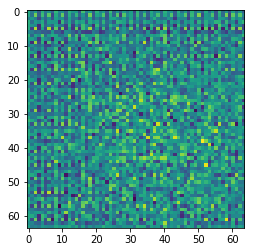

In [254]:
plt.imshow(generator.predict(np.random.normal(size=(1, 4*4*512)))[0])

In [240]:
loss_df = pd.DataFrame(all_losses, columns=["disc_real", "disc_fake", "disc_tot", "generator"])

Text(0, 0.5, 'Error')

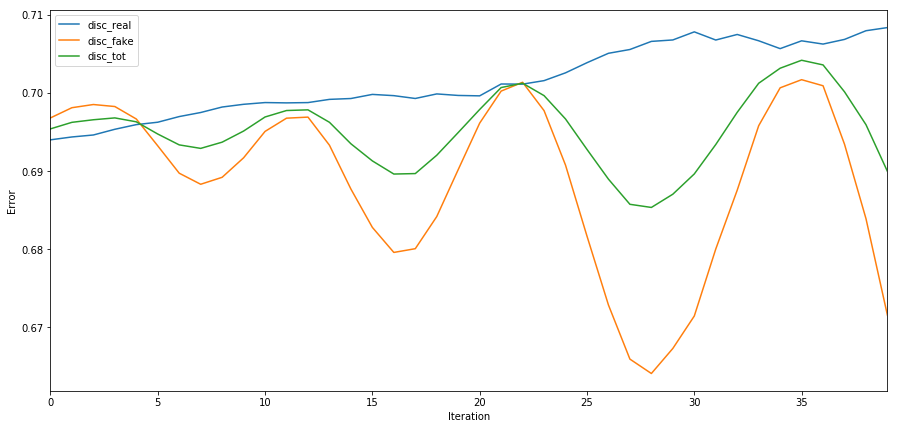

In [241]:
ax = loss_df.iloc[:, :3].apply(lambda col: col.str[0], axis=1).plot(
    figsize=(15, 7))
ax.set_xlabel("Iteration")
ax.set_ylabel("Error")

Text(0, 0.5, 'Accuracy')

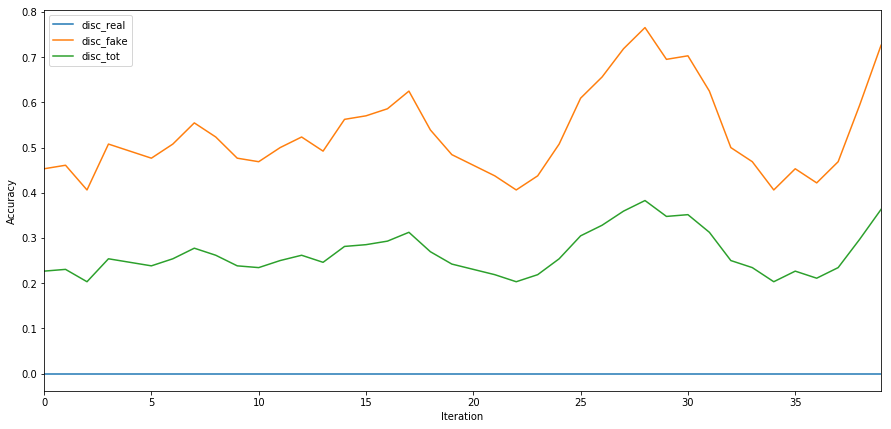

In [242]:
ax = loss_df.iloc[:, :3].apply(lambda col: col.str[1], axis=1).plot(
    figsize=(15, 7))
ax.set_xlabel("Iteration")
ax.set_ylabel("Accuracy")

Text(0, 0.5, 'Generator Error')

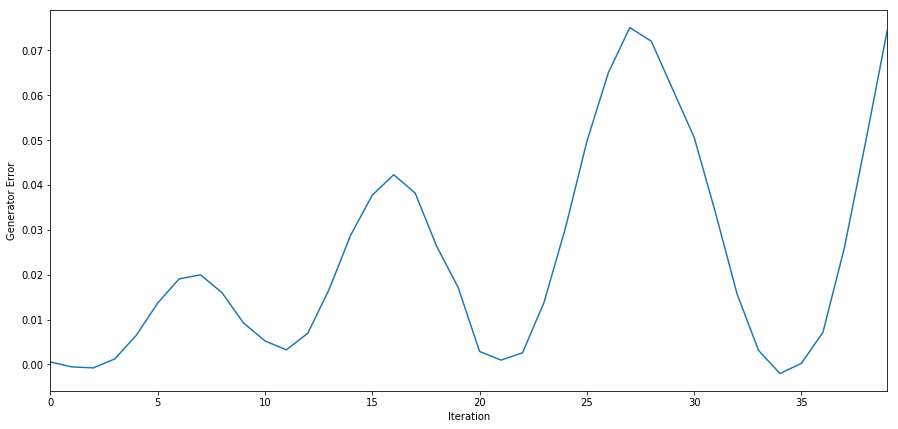

In [250]:
ax = loss_df["generator"].str[0].plot(
    figsize=(15, 7))
ax.set_xlabel("Iteration")
ax.set_ylabel("Generator Error")

In [233]:
full_model.predict(np.random.normal(size=(10, 4*4*512)))

array([[0.52880514],
       [0.48851696],
       [0.5032899 ],
       [0.5098127 ],
       [0.50797796],
       [0.50065315],
       [0.5001941 ],
       [0.5188927 ],
       [0.51672965],
       [0.49920994]], dtype=float32)